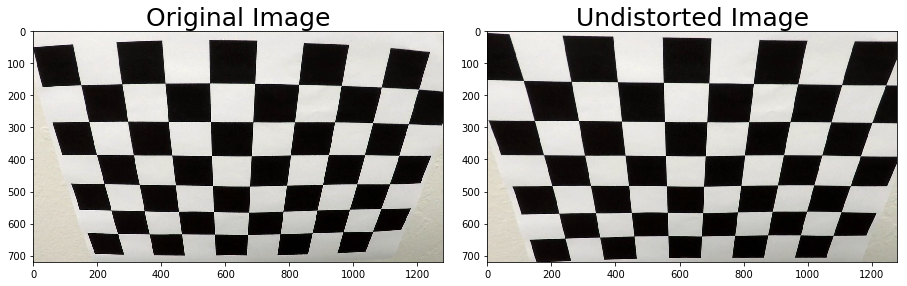

In [1]:
#################################
# Calibrate the camera
##############################

import cv2
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import glob

# Read in the images
images = glob.glob('camera_cal\calibration*.jpg')

#test_img = mpimg.imread('calibration2.jpg')
#plt.imshow(test_img)
#plt.show()

# Points used to calibrate the camera
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane

nx = 9 # Number of corners in x direction
ny = 6 # Number of corners in y direction

objp = np.zeros((nx*ny,3), np.float32)
objp[:,:2] = np.mgrid[0:nx,0:ny].T.reshape(-1,2)

# Cycle through each image gathering points for camera calibration
for fname in images:
    img = mpimg.imread(fname) # read the image into an numpy array
    
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (nx, ny), None)

    # If corners are found
    if ret == True:
        # add image points and object points
        imgpoints.append(corners)
        objpoints.append(objp)

        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (nx, ny), corners, ret)

ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)

# show undistorted images
fname = images[10] #select an original image to display
original_img = mpimg.imread(fname) # read the original image into an numpy array
undistorted_img = cv2.undistort(original_img, mtx, dist, None, mtx)
    
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(original_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()


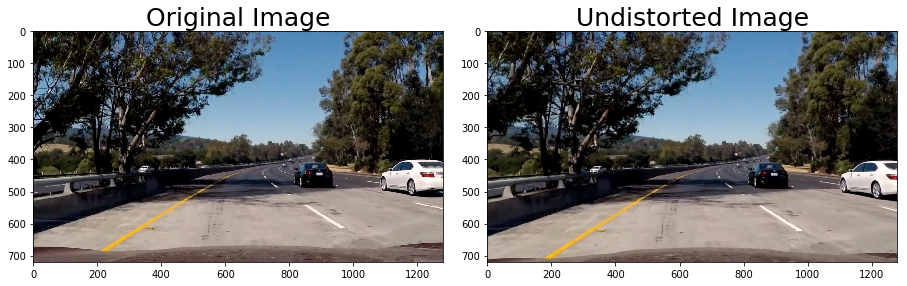

In [66]:
#Apply distortion correction to a road image

fname = 'test_images\\test5.jpg' #select an original image to display
original_img = mpimg.imread(fname) # read the original image into an numpy array
undistorted_img = cv2.undistort(original_img, mtx, dist, None, mtx)
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
f.tight_layout()
ax1.imshow(original_img)
ax1.set_title('Original Image', fontsize=25)
ax2.imshow(undistorted_img)
ax2.set_title('Undistorted Image', fontsize=25)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [67]:
# Use color transforms, gradients, etc., to create a thresholded binary image.

#########################################################
# Define gradient and color thresholding methods
######################################

# Define a function that takes an image, gradient orientation,
# and threshold min / max values.
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh_min=0, thresh_max=255): 
    # Apply the following steps to img
    # 1) Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # 2) Take the derivative in x or y given orient = 'x' or 'y'
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    else:  # assume 'y'
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # 3) Take the absolute value of the derivative or gradient
    abs_sobel = np.absolute(sobel)
    # 4) Scale to 8-bit (0 - 255) then convert to type = np.uint8
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # 5) Create a mask of 1's where the scaled gradient magnitude
            # is > thresh_min and < thresh_max
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 1
    # 6) Return this mask as the binary_output image
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Convert to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8-bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    binary_output = np.zeros_like(gradmag)
    binary_output[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 1
    # Return the binary image
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    binary_output =  np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    # Return the binary image
    return binary_output

# Define a function that thresholds the S-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_S_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    S = hls_image[:,:,2]
    # 2) Apply a threshold to the S channel
    binary_output = np.zeros_like(S)
    binary_output[(S > thresh[0]) & (S <= thresh[1])] = 1
    return binary_output

# Define a function that thresholds the L-channel of HLS
# Use exclusive lower bound (>) and inclusive upper (<=)
def hls_L_select(img, thresh=(0, 255)):
    # 1) Convert to HLS color space
    hls_image = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    L = hls_image[:,:,1]
    # 2) Apply a threshold to the L channel
    binary_output = np.zeros_like(L)
    binary_output[(L > thresh[0]) & (L <= thresh[1])] = 1
    return binary_output

########################################
# Apply thresholding
##########################

# Choose a Sobel kernel size
ksize = 15 # Choose a larger odd number to smooth gradient measurements

# Apply the thresholding methods
grad_x_binary = abs_sobel_thresh(undistorted_img, orient='x', thresh_min=20, thresh_max=100)
grad_y_binary = abs_sobel_thresh(undistorted_img, orient='y', thresh_min=20, thresh_max=100)
mag_binary = mag_thresh(undistorted_img, sobel_kernel=ksize, mag_thresh=(30, 200))
dir_binary = dir_threshold(undistorted_img, sobel_kernel=ksize, thresh=(0.7, 1.3))
hls_L_binary = hls_L_select(undistorted_img, thresh=(90, 175))
hls_S_binary = hls_S_select(undistorted_img, thresh=(90, 250))

combined_binary = np.zeros_like(dir_binary)
combined_binary[((grad_x_binary == 1) & (grad_y_binary == 1))
                | ((mag_binary == 1) & (dir_binary == 1)) 
                | ((hls_S_binary == 1) )] = 1



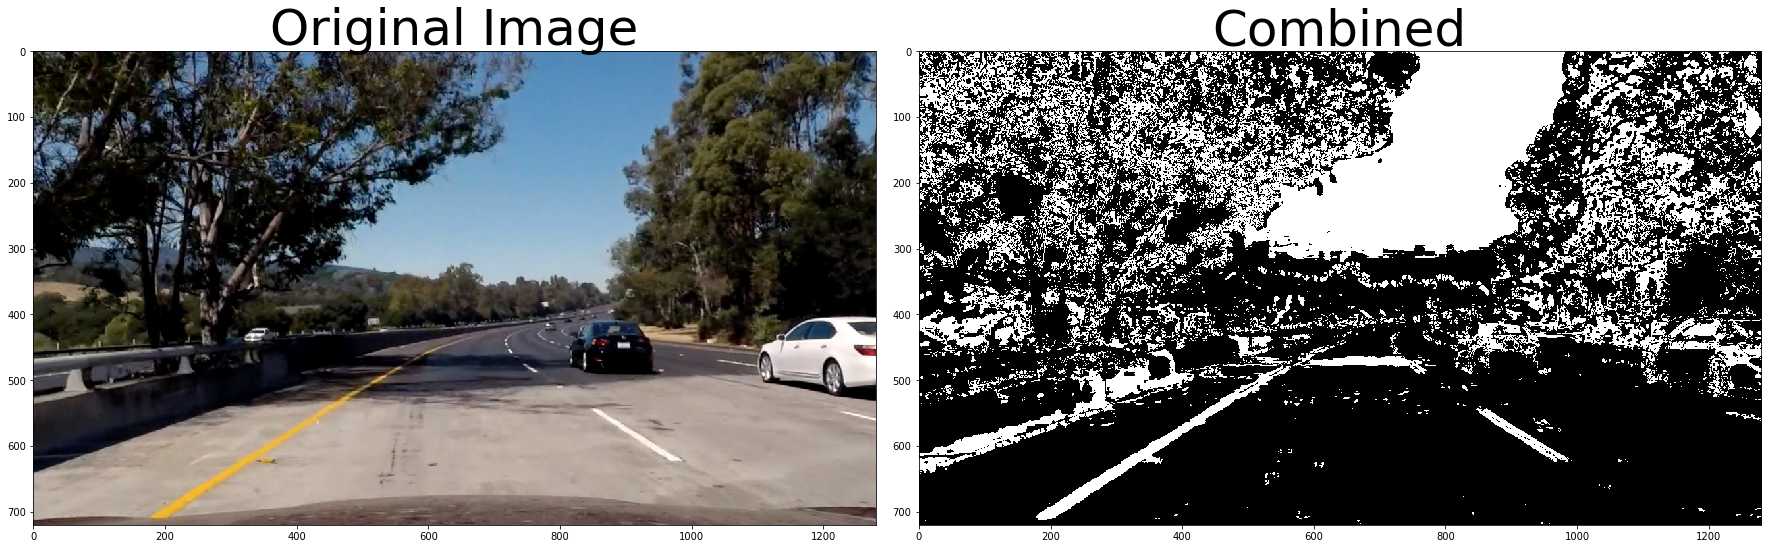

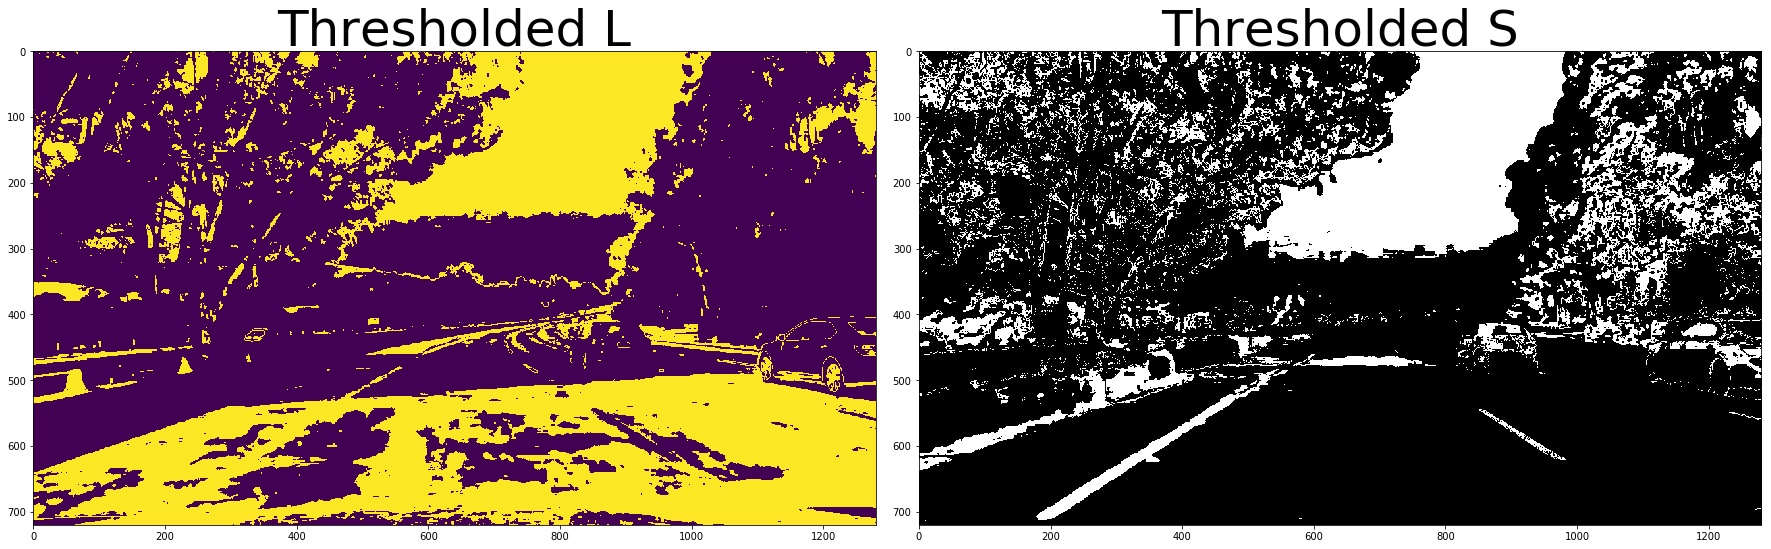

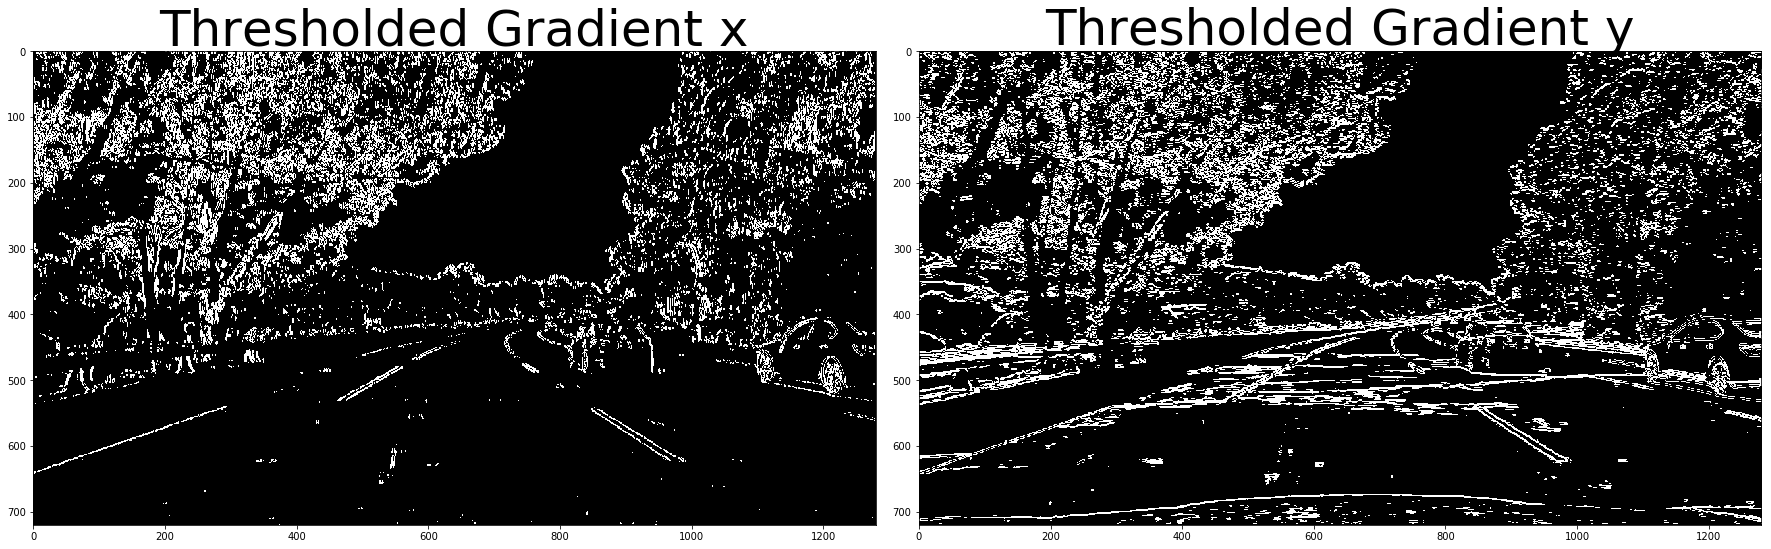

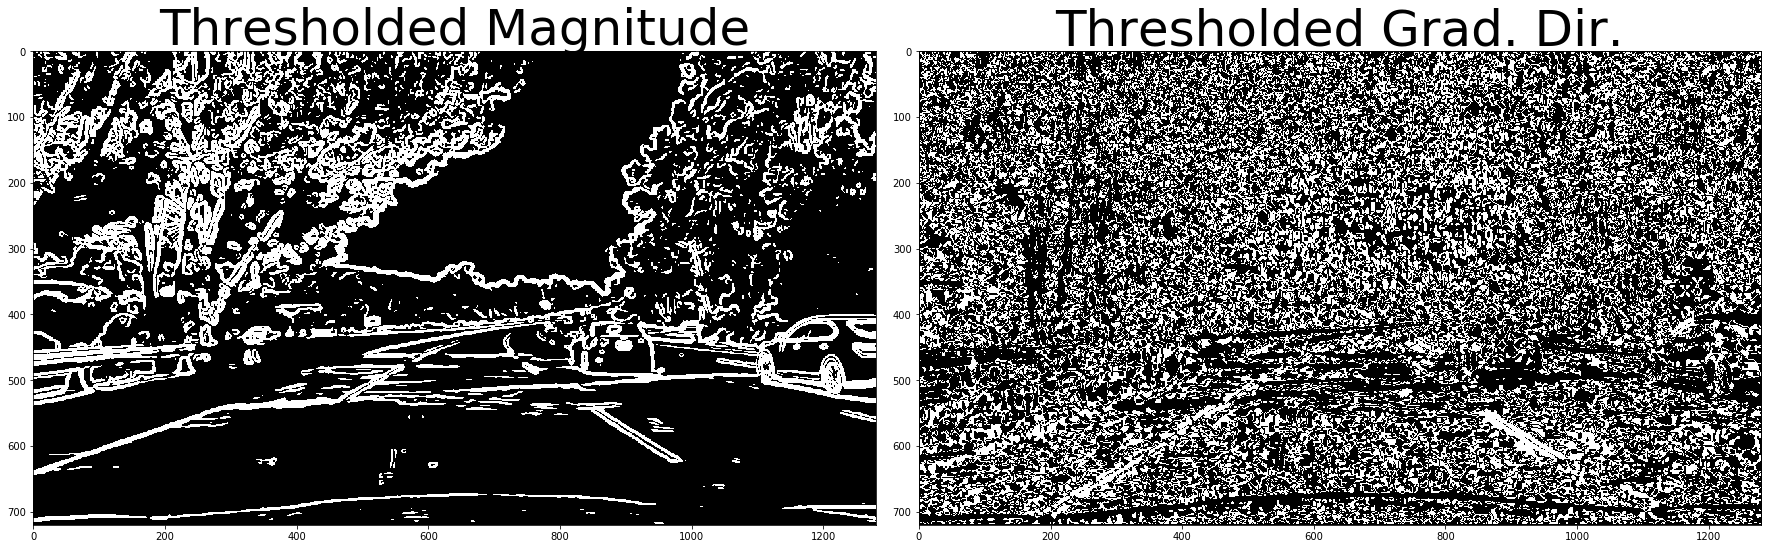

In [68]:
######################################################
# Display thresholding images
########################################

# Plot the Original and Combined images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(undistorted_img)
ax1.set_title('Original Image', fontsize=50)
ax2.imshow(combined_binary, cmap='gray')
ax2.set_title('Combined', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Plot the HLS L & S images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(hls_L_binary)
ax1.set_title('Thresholded L', fontsize=50)
ax2.imshow(hls_S_binary, cmap='gray')
ax2.set_title('Thresholded S', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# PLot the gradient x and y images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(grad_x_binary, cmap='gray')
ax1.set_title('Thresholded Gradient x', fontsize=50)
ax2.imshow(grad_y_binary, cmap='gray')
ax2.set_title('Thresholded Gradient y', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

# Plot the magnitude and direction gradient images
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
f.tight_layout()
ax1.imshow(mag_binary, cmap='gray')
ax1.set_title('Thresholded Magnitude', fontsize=50)
ax2.imshow(dir_binary, cmap='gray')
ax2.set_title('Thresholded Grad. Dir.', fontsize=50)
plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
plt.show()

In [ ]:
#M = cv2.getPerspectiveTransform(src, dst)
#Compute the inverse perspective transform:

#Minv = cv2.getPerspectiveTransform(dst, src)
#Warp an image using the perspective transform, M:

#warped = cv2.warpPerspective(img, M, img_size, flags=cv2.INTER_LINEAR)



In [ ]:
# TODO:
# Doesn't size images correctly.  Saving to fix later.
# show undistorted images
fig, axes = plt.subplots(nrows=len(images), ncols=2)
print(axes.shape)
plt.figure(figsize=(2000,2000))

for i in range(len(images)):
    
    fname = images[i] #select an original image to display
    original_img = mpimg.imread(fname) # read the original image into an numpy array
    undistorted_img = cv2.undistort(original_img, mtx, dist, None, mtx)

    axes[i,0].imshow(original_img)
    axes[i,0].figure(figsize=(1000,1000))
    axes[i,0].set_title("original")

    axes[i,1].imshow(undistorted_img)
    axes[i,1].figure(figsize=(1000,1000))
    axes[i,1].set_title("undistorted")
    plt.show()
